In [3]:
# import libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import numpy as np
import os
import pandas as pd

In [4]:
#area_one_pixel_cm2 = (1.27/700)**2
area_one_pixel = (12.7/700)**2

In [3]:
def display_images(image, model_result, ground_truth):
    """
    Display the leaf image, model result, and ground truth side by side.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("leaf")

    plt.subplot(1, 3, 2)
    plt.imshow(model_result)
    plt.title("result")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("ground_truth")


def format_ground_truth(ground_truth):
    """
    Format the ground truth image using specific target values.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    numpy.ndarray: The formatted ground truth image.
    """

    # Define the target values for the ground truth image
    target_values = np.array([63, 127, 191, 255])

    # Define the bins for the ground truth image
    bins = np.array([0, 95, 159, 223, 255])

    # Convert the ground truth image to a 1D array
    indices = np.digitize(ground_truth, bins) - 1

    # Ensure that the indices are within the range of the target values
    valid_indices = np.where(indices < len(target_values), indices, len(target_values) - 1)

    # Create the formatted ground truth image
    ground_truth = target_values[valid_indices]

    # Convert the formatted ground truth image to the original shape
    ground_truth = ground_truth.astype(np.uint8)

    return ground_truth


def format_images(model_result, ground_truth):
    """
    Format the images by converting them to grayscale and flattening them.
    
    Parameters:
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    tuple: The formatted model result and ground truth images.
    """

    # Convert images to grayscale
    model_result = cv2.cvtColor(model_result, cv2.COLOR_RGB2GRAY)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

    # Flatten the images
    model_result = model_result.flatten()
    ground_truth = ground_truth.flatten()

    return model_result, ground_truth


def label_metrics(ground_truth, model_result, class_label):
    """
    Calculate metrics for a specific class.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    model_result (numpy.ndarray): The image produced by the model.
    class_label (int): The label of the class for which to calculate the metrics.

    Returns:
    tuple: The precision, recall, F1 score, and IoU for the class.
    """

    precision = precision_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    recall = recall_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    f1 = f1_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    iou = jaccard_score(ground_truth, model_result, labels=[class_label], average=None)[0]

    # Calculate the surface error
    ground_truth_surface = np.sum(ground_truth == class_label)
    model_result_surface = np.sum(model_result == class_label)
    surface_error_pixels = abs(ground_truth_surface - model_result_surface)

    ground_truth_surface_cm2 = ground_truth_surface * area_one_pixel
    model_result_surface_cm2 = model_result_surface * area_one_pixel
    surface_error_cm2 = abs(ground_truth_surface_cm2 - model_result_surface_cm2)


    surface_error_percent = (abs(ground_truth_surface - model_result_surface) / ground_truth_surface)*100 if ground_truth_surface > 0 else 0

    return precision, recall, f1, iou, ground_truth_surface_cm2, model_result_surface_cm2 ,surface_error_cm2, surface_error_percent


def global_metrics(ground_truth, result):
    """
    Calculate the global metrics.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    result (numpy.ndarray): The image produced by the model.

    Returns:
    tuple: The mean average precision (mAP) and accuracy.
    """

    mAP = precision_score(ground_truth, result, average='macro', zero_division=1)
    accuracy = accuracy_score(ground_truth, result)

    return mAP, accuracy


def process_images_and_calculate_metrics(image, model_result, ground_truth):
    """
    Process the images and calculate the metrics.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    # Format the images
    model_result_reshaped = format_ground_truth(model_result)
    ground_truth_reshaped = format_ground_truth(ground_truth)

    model_result, ground_truth = format_images(model_result, ground_truth)

    # Calculate the metrics for each class
    code = {'BACKGROUND':63 ,'LEAF':127, 'RUST':255, 'OIDIUM':191}

    for class_name, class_label in code.items():
        precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2,surface_error_cm2, surface_error_percent = label_metrics(ground_truth, model_result, class_label=class_label)
        print(f"Class: {class_name}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"IoU: {IoU:.3f}")
        print(f"Ground truth surface : {ground_truth_surface_cm2:.3f} cm2")
        print(f"Model result surface : {model_result_surface_cm2:.3f} cm2")
        print(f"Surface error : {surface_error_cm2:.3f} cm2")
        print(f"Area error : {surface_error_percent:.3f} %")
        print("\n")

    # Calculate the global metrics
    mAP, accuracy = global_metrics(ground_truth, model_result)
    print(f"mAP: {mAP}")
    print(f"Accuracy: {accuracy}")

    # Reshape the images to the original shape for display
    model_result.reshape((image.shape[1], image.shape[0], 1))
    ground_truth.reshape((image.shape[1], image.shape[0], 1))

    # Display the images
    display_images(image, model_result_reshaped, ground_truth_reshaped)

Class: BACKGROUND
Precision: 0.969
Recall: 0.987
F1-score: 0.978
IoU: 0.957
Ground truth surface : 13.072 cm2
Model result surface : 13.313 cm2
Surface error : 0.241 cm2
Area error : 1.846 %


Class: LEAF
Precision: 0.980
Recall: 0.986
F1-score: 0.983
IoU: 0.966
Ground truth surface : 25.341 cm2
Model result surface : 25.505 cm2
Surface error : 0.164 cm2
Area error : 0.645 %


Class: RUST
Precision: 0.500
Recall: 0.830
F1-score: 0.624
IoU: 0.453
Ground truth surface : 0.052 cm2
Model result surface : 0.086 cm2
Surface error : 0.034 cm2
Area error : 66.130 %


Class: OIDIUM
Precision: 0.350
Recall: 0.541
F1-score: 0.425
IoU: 0.270
Ground truth surface : 0.343 cm2
Model result surface : 0.529 cm2
Surface error : 0.187 cm2
Area error : 54.428 %


mAP: 0.9799738029239425
Accuracy: 0.9666015292408888


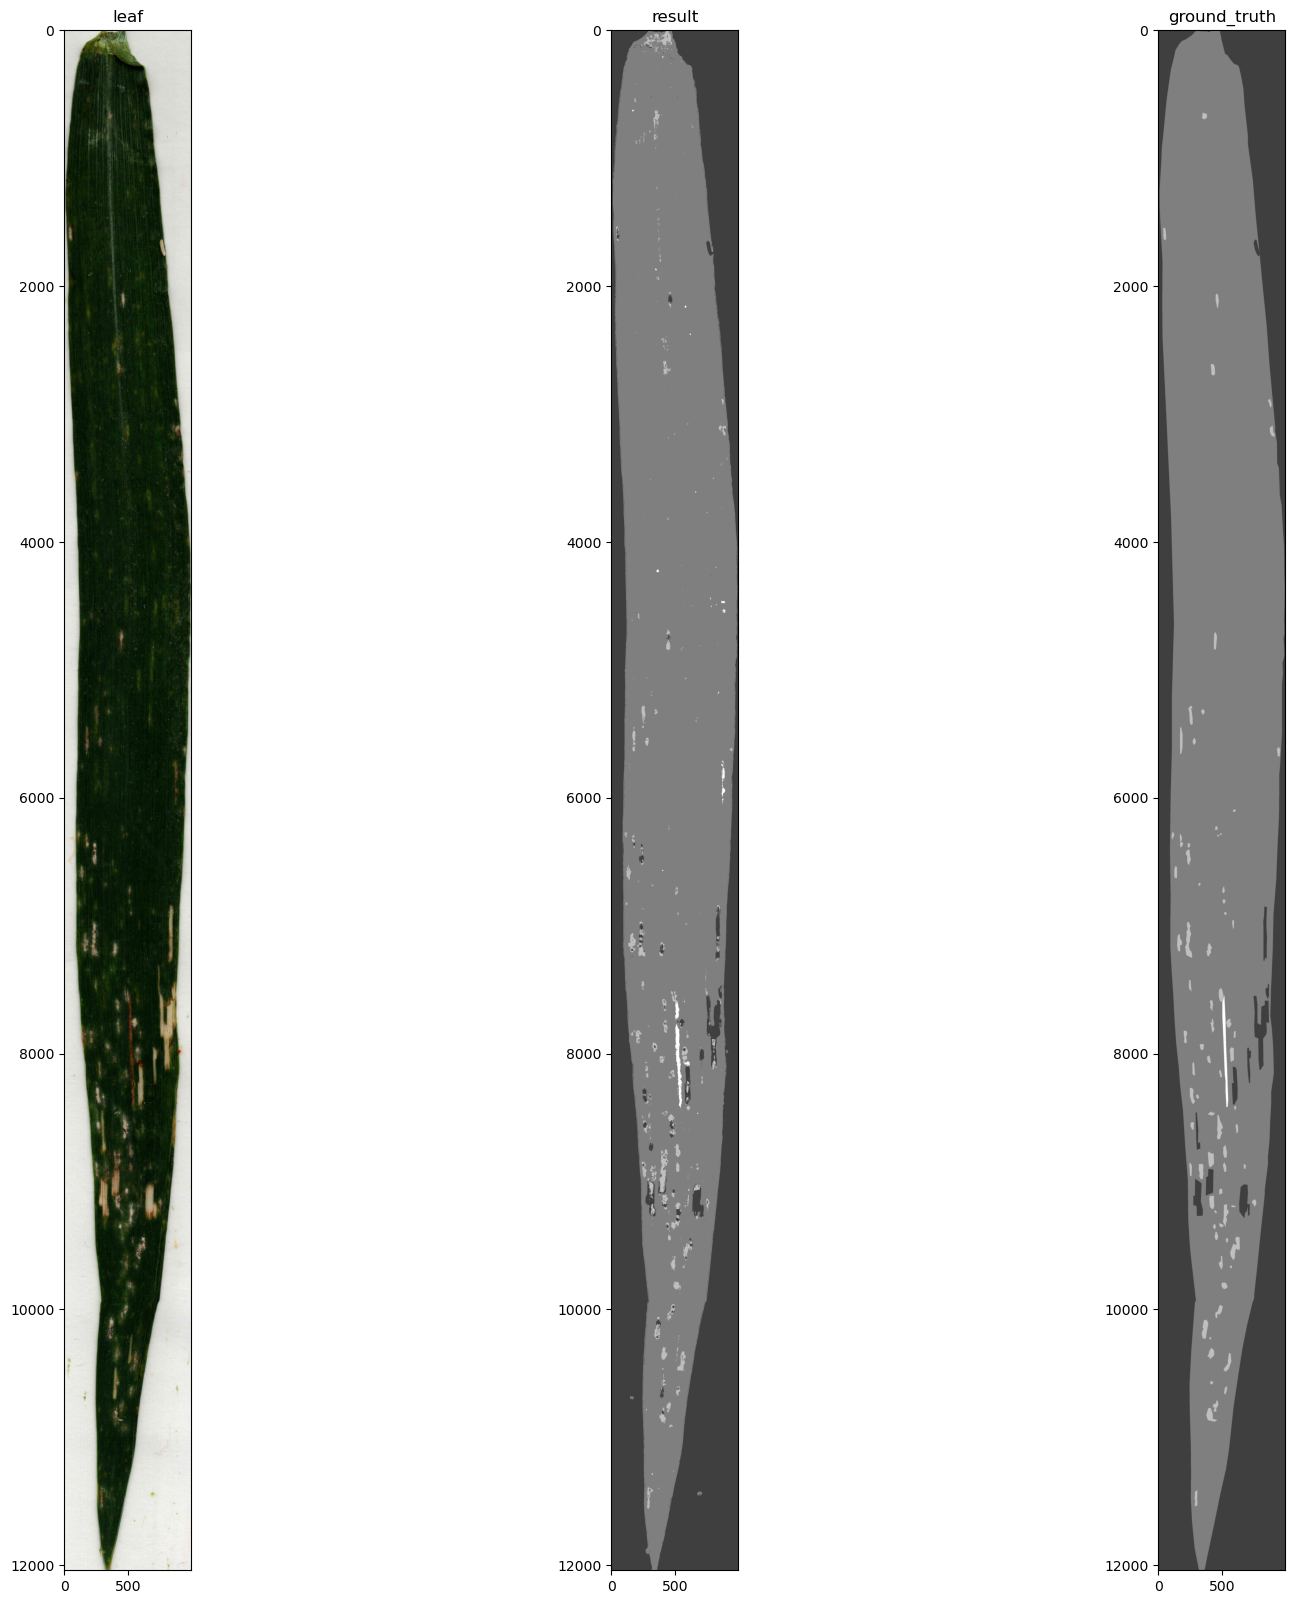

In [10]:
image_path = "test_images/654_leaf4.jpg"

# Get the name of the file without the extension
base_name = os.path.basename(image_path)
file_name, extension = os.path.splitext(base_name)


# Define the paths to the model result and ground truth images
model_result_path = os.path.join("/Users/titouanlegourrierec/Desktop/classfier_T/", f"{file_name}_Simple_Segmentation.png")
ground_truth_path = os.path.join("ground_truth/", f"{file_name}_ground_truth{extension}")

# Load the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model_result = cv2.imread(model_result_path)
model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

ground_truth = cv2.imread(ground_truth_path)
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

# Process the images and calculate the metrics
process_images_and_calculate_metrics(image, model_result, ground_truth)

---
# Average Metrics

In [45]:
def display_images(image, model_result, ground_truth):
    """
    Display the leaf image, model result, and ground truth side by side.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("leaf")

    plt.subplot(1, 3, 2)
    plt.imshow(model_result)
    plt.title("result")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("ground_truth")


def format_ground_truth(ground_truth):
    """
    Format the ground truth image using specific target values.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    numpy.ndarray: The formatted ground truth image.
    """

    # Define the target values for the ground truth image
    target_values = np.array([63, 127, 191, 255])

    # Define the bins for the ground truth image
    bins = np.array([0, 95, 159, 223, 255])

    # Convert the ground truth image to a 1D array
    indices = np.digitize(ground_truth, bins) - 1

    # Ensure that the indices are within the range of the target values
    valid_indices = np.where(indices < len(target_values), indices, len(target_values) - 1)

    # Create the formatted ground truth image
    ground_truth = target_values[valid_indices]

    # Convert the formatted ground truth image to the original shape
    ground_truth = ground_truth.astype(np.uint8)

    return ground_truth


def format_images(model_result, ground_truth):
    """
    Format the images by converting them to grayscale and flattening them.
    
    Parameters:
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    tuple: The formatted model result and ground truth images.
    """

    # Convert images to grayscale
    model_result = cv2.cvtColor(model_result, cv2.COLOR_RGB2GRAY)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

    # Flatten the images
    model_result = model_result.flatten()
    ground_truth = ground_truth.flatten()

    return model_result, ground_truth


def label_metrics(ground_truth, model_result, class_label):
    """
    Calculate metrics for a specific class.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    model_result (numpy.ndarray): The image produced by the model.
    class_label (int): The label of the class for which to calculate the metrics.

    Returns:
    tuple: The precision, recall, F1 score, and IoU for the class.
    """

    precision = precision_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    recall = recall_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    f1 = f1_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    iou = jaccard_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]

    # Calculate the surface error
    ground_truth_surface = np.sum(ground_truth == class_label)
    model_result_surface = np.sum(model_result == class_label)
    surface_error_pixels = abs(ground_truth_surface - model_result_surface)

    ground_truth_surface_mm2 = ground_truth_surface * area_one_pixel
    model_result_surface_mm2 = model_result_surface * area_one_pixel
    surface_error_cm2 = abs(ground_truth_surface_mm2 - model_result_surface_mm2)


    surface_error_percent = (abs(ground_truth_surface - model_result_surface) / ground_truth_surface)*100 if ground_truth_surface > 0 else 0

    return precision, recall, f1, iou, ground_truth_surface_mm2, model_result_surface_mm2 ,surface_error_cm2, surface_error_percent


def global_metrics(ground_truth, result):
    """
    Calculate the global metrics.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    result (numpy.ndarray): The image produced by the model.

    Returns:
    tuple: The mean average precision (mAP) and accuracy.
    """

    mAP = precision_score(ground_truth, result, average='macro', zero_division=1)
    accuracy = accuracy_score(ground_truth, result)

    return mAP, accuracy


def process_images_and_calculate_metrics(image, model_result, ground_truth):
    """
    Process the images and calculate the metrics.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    # Format the images
    model_result_reshaped = format_ground_truth(model_result)
    ground_truth_reshaped = format_ground_truth(ground_truth)

    model_result, ground_truth = format_images(model_result, ground_truth)

    # Initialize an empty list to store the metrics
    metrics = []

    # Calculate the metrics for each class
    code = {'BACKGROUND':63 ,'LEAF':127, 'RUST':255, 'OIDIUM':191} #TITOUAN
    #code = {'BACKGROUND':255 ,'LEAF':191, 'RUST':63, 'OIDIUM':127} #LENA

    for class_name, class_label in code.items():
        precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2,surface_error_cm2, surface_error_percent = label_metrics(ground_truth, model_result, class_label=class_label)
        
        # Append the metrics for the current class to the list
        metrics.append([class_name, precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2, surface_error_cm2, surface_error_percent])

    return metrics

In [141]:
#images = ["test_images/111_leaf2.jpg", "test_images/654_leaf4.jpg", "test_images/664_leaf3.jpg", "test_images/672_leaf2.jpg", "test_images/684_leaf3.jpg"]

# liste de tous les chemins des images du dossier dir
dir = "/Users/titouanlegourrierec/Desktop/PATCHS/LAB"
images = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

# Initialize dictionaries to store the sum of each metric for each class and the count of each class
metrics_sum = { 'precision': {}, 'recall': {}, 'f1': {}, 'IoU': {}, 'ground_truth_surface_cm2': {}, 'model_result_surface_cm2': {}, 'surface_error_cm2': {}, 'surface_error_percent': {} }
count = { 'precision': {}, 'recall': {}, 'f1': {}, 'IoU': {}, 'ground_truth_surface_cm2': {}, 'model_result_surface_cm2': {}, 'surface_error_cm2': {}, 'surface_error_percent': {} }

for image_path in images:
    # Get the name of the file without the extension
    base_name = os.path.basename(image_path)
    file_name, extension = os.path.splitext(base_name)

    if extension in ['.png', '.jpg']:
        # Define the paths to the model result and ground truth images
        model_result_path = os.path.join("/Users/titouanlegourrierec/Desktop/PATCHS/essai_morph_RGB/", f"{file_name}_Simple_Segmentation.png")
        ground_truth_path = os.path.join("/Users/titouanlegourrierec/Desktop/PATCHS/mask/", f"{file_name}_ground_truth{extension}")

        # Load the images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        model_result = cv2.imread(model_result_path)
        model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

        ground_truth = cv2.imread(ground_truth_path)
        ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

        # Process the images and calculate the metrics
        metrics = process_images_and_calculate_metrics(image, model_result, ground_truth)

        # Add the metrics to the sum and increment the count for each class
        for class_metrics in metrics:
            class_name = class_metrics[0]
            metrics_values = class_metrics[1:]
            
            for metric, value in zip(['precision', 'recall', 'f1', 'IoU', 'ground_truth_surface_cm2', 'model_result_surface_cm2', 'surface_error_cm2', 'surface_error_percent'], metrics_values):
                if metric in ['precision', 'recall', 'f1'] and (value == 0 or value == 1):
                    continue
                if class_name not in metrics_sum[metric]:
                    metrics_sum[metric][class_name] = value
                    count[metric][class_name] = 1
                else:
                    metrics_sum[metric][class_name] += value
                    count[metric][class_name] += 1

# Calculate the average of each metric for each class
average_metrics = { metric: { class_name: value / count[metric][class_name] for class_name, value in class_values.items() } for metric, class_values in metrics_sum.items() }

# Now, 'average_metrics' is a dictionary where the keys are the metric names and the values are dictionaries with the class names as keys and the average metrics for each class as values
for metric, class_values in average_metrics.items():
    print("\n")
    for class_name, average_value in class_values.items():
        print(f"Average {metric} for {class_name}: {average_value:.3f}")



Average precision for LEAF: 0.805
Average precision for RUST: 0.963
Average precision for OIDIUM: 0.851
Average precision for BACKGROUND: 0.989


Average recall for BACKGROUND: 0.756
Average recall for LEAF: 0.945
Average recall for RUST: 0.848
Average recall for OIDIUM: 0.980


Average f1 for BACKGROUND: 0.827
Average f1 for LEAF: 0.859
Average f1 for RUST: 0.893
Average f1 for OIDIUM: 0.908


Average IoU for BACKGROUND: 0.770
Average IoU for LEAF: 0.702
Average IoU for RUST: 0.756
Average IoU for OIDIUM: 0.629


Average ground_truth_surface_cm2 for BACKGROUND: 34.748
Average ground_truth_surface_cm2 for LEAF: 43.218
Average ground_truth_surface_cm2 for RUST: 34.145
Average ground_truth_surface_cm2 for OIDIUM: 28.393


Average model_result_surface_cm2 for BACKGROUND: 26.213
Average model_result_surface_cm2 for LEAF: 52.046
Average model_result_surface_cm2 for RUST: 29.177
Average model_result_surface_cm2 for OIDIUM: 33.070


Average surface_error_cm2 for BACKGROUND: 8.662
Average su

In [50]:
import pandas as pd

# Initialize a list to store the data for each image
data = []

# liste de tous les chemins des images du dossier dir
dir = "/Users/titouanlegourrierec/Desktop/PATCHS/LAB"
images = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

for image_path in images:
    # Get the name of the file without the extension
    base_name = os.path.basename(image_path)
    file_name, extension = os.path.splitext(base_name)

    if extension in ['.png', '.jpg']:
        # Define the paths to the model result and ground truth images
        model_result_path = os.path.join("/Users/titouanlegourrierec/Desktop/PATCHS/essai_morph_LAB/", f"{file_name}_Simple_segmentation.png")
        ground_truth_path = os.path.join("/Users/titouanlegourrierec/Desktop/PATCHS/mask/", f"{file_name}_ground_truth{extension}")

        # Load the images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        model_result = cv2.imread(model_result_path)
        model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

        ground_truth = cv2.imread(ground_truth_path)
        ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

        # Process the images and calculate the metrics
        metrics = process_images_and_calculate_metrics(image, model_result, ground_truth)

        # Store the metrics for this image in the data list
        for class_metrics in metrics:
            class_name = class_metrics[0]
            metrics_values = class_metrics[1:]
            
            image_data = {'image': file_name, 'class': class_name}
            for metric, value in zip(['precision', 'recall', 'f1', 'IoU', 'ground_truth_surface_cm2', 'model_result_surface_cm2', 'surface_error_cm2', 'surface_error_percent'], metrics_values):
                if metric in ['precision', 'recall', 'f1'] and (value == 0 or value == 1):
                    continue
                image_data[metric] = value
            data.append(image_data)

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Now, 'df' is a DataFrame where each row corresponds to an image and each column to a metric
print(df)

   image       class  precision    recall        f1       IoU  \
0      8  BACKGROUND   0.982788  0.429430  0.597697  0.426225   
1      8        LEAF   0.798579  0.975485  0.878212  0.782868   
2      8        RUST   0.974173  0.891262  0.930875  0.870688   
3      8      OIDIUM   0.877047  0.999474  0.934267  0.876643   
4      9  BACKGROUND   0.999787  0.705879  0.827511  0.705773   
5      9        LEAF   0.788743  0.987139  0.876859  0.780720   
6      9        RUST   0.983383  0.921100  0.951223  0.906983   
7      9      OIDIUM        NaN       NaN       NaN  0.000000   
8     13  BACKGROUND   0.999832  0.264868  0.418793  0.264857   
9     13        LEAF   0.789779  0.982615  0.875707  0.778895   
10    13        RUST        NaN       NaN       NaN  0.000000   
11    13      OIDIUM   0.893653  0.997260  0.942618  0.891465   
12    11  BACKGROUND        NaN  0.923403  0.960176  0.923403   
13    11        LEAF   0.920755  0.987368  0.952899  0.910036   
14    11        RUST   0.

In [51]:
# enregistre df en csv
df.to_csv("/Users/titouanlegourrierec/Desktop/PATCHS/excel_results/LAB2", index=False)

In [148]:
import pandas as pd
# Charger le fichier CSV
df = pd.read_csv("/Users/titouanlegourrierec/Desktop/new_ANNOT/new_excels/metrics_new_LAB2.csv")

In [113]:
df

,image,class,precision,recall,f1,IoU,ground_truth_surface_cm2,model_result_surface_cm2,surface_error_cm2,surface_error_percent
0,45_leaf2,BACKGROUND,0.944005,0.972826,0.958199,0.919752,1304.554007,1344.383421,39.829413,3.053106
1,45_leaf2,LEAF,0.985516,0.975122,0.980291,0.961344,2704.844492,2676.317886,28.526605,1.054649
2,45_leaf2,RUST,0.120464,0.400963,0.185267,0.102091,4.646469,15.465736,10.819267,232.849249
3,45_leaf2,OIDIUM,0.067195,0.427834,0.116149,0.061655,5.293274,33.702368,28.409094,536.701698
4,478_leaf5,BACKGROUND,0.946694,0.997897,0.971622,0.944809,569.714134,600.527436,30.813302,5.408555
...,...,...,...,...,...,...,...,...,...,...
107,304_leaf1,OIDIUM,0.565164,0.519042,0.541122,0.370916,9.014794,8.279114,0.735680,8.160806
108,16_leaf2,BACKGROUND,0.946560,0.999652,0.972382,0.946248,923.622248,975.428266,51.806019,5.609005
109,16_leaf2,LEAF,0.997813,0.986355,0.992051,0.984227,2337.290915,2310.450942,26.839973,1.148337
110,16_leaf2,RUST,NaN,NaN,NaN,0.000000,0.440750,0.000329,0.440420,99.925317


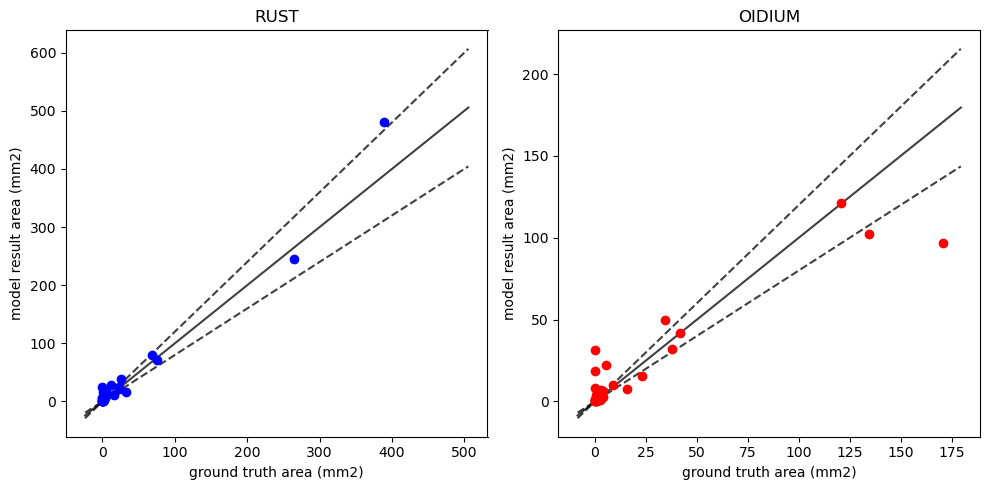

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for rows where class is 'RUST' or 'OIDIUM'
df_rust = df[df['class'] == 'RUST']
df_oidium = df[df['class'] == 'OIDIUM']

# Create a new figure with 2 subplots horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'RUST' class
axs[0].scatter(df_rust['ground_truth_surface_cm2'], df_rust['model_result_surface_cm2'], color='blue')
axs[0].set_title('RUST')

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'OIDIUM' class
axs[1].scatter(df_oidium['ground_truth_surface_cm2'], df_oidium['model_result_surface_cm2'], color='red')
axs[1].set_title('OIDIUM')

# Add a y=x reference line and two dashed lines at y=x±5% to both subplots
for ax in axs:
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # y=x line
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
    # y=x+5% line
    ax.plot(lims, [lim*1.2 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    # y=x-5% line
    ax.plot(lims, [lim*0.8 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    ax.set_xlabel('ground truth area (mm2)')
    ax.set_ylabel('model result area (mm2)')

    #ax.grid(True)
    #ax.set_axisbelow(True)

# Adjust the layout
plt.tight_layout()

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/feuilles/area_feuille_YUV.pdf", format='pdf')

# Show the plot
plt.show()

/var/folders/bm/bfchd71s5dj_my2slhz34b340000gn/T/ipykernel_3525/1428373676.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bm/bfchd71s5dj_my2slhz34b340000gn/T/ipykernel_3525/1428373676.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



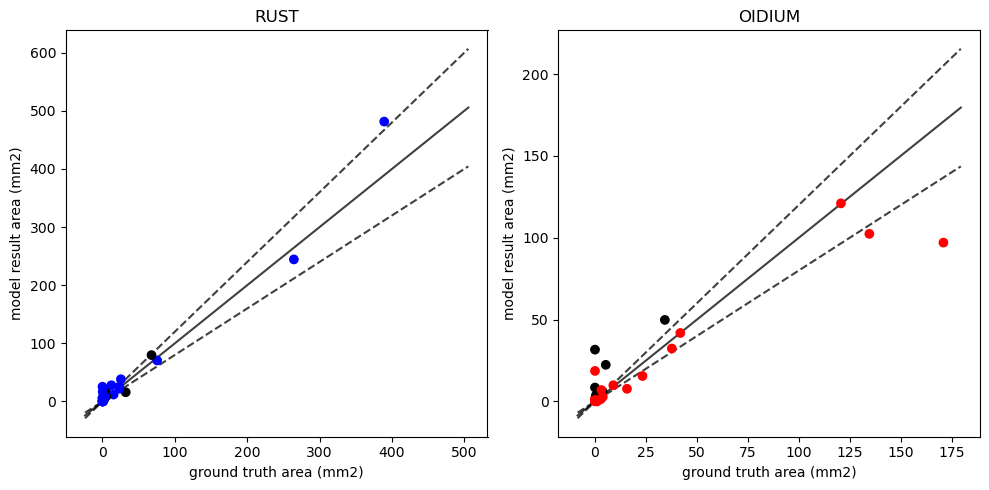

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Liste des noms des feuilles à colorer en orange
orange_leaves = ["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5", "45_leaf2", "410_leaf2"]

# Filter the DataFrame for rows where class is 'RUST' or 'OIDIUM'
df_rust = df[df['class'] == 'RUST']
df_oidium = df[df['class'] == 'OIDIUM']

# Créer une nouvelle colonne 'color' qui contient la couleur des points
df_rust['color'] = np.where(df_rust['image'].isin(orange_leaves), 'black', 'blue')
df_oidium['color'] = np.where(df_oidium['image'].isin(orange_leaves), 'black', 'red')

# Create a new figure with 2 subplots horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'RUST' class
axs[0].scatter(df_rust['ground_truth_surface_cm2'], df_rust['model_result_surface_cm2'], color=df_rust['color'])
axs[0].set_title('RUST')

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'OIDIUM' class
axs[1].scatter(df_oidium['ground_truth_surface_cm2'], df_oidium['model_result_surface_cm2'], color=df_oidium['color'])
axs[1].set_title('OIDIUM')

# Add a y=x reference line and two dashed lines at y=x±5% to both subplots
for ax in axs:
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # y=x line
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
    # y=x+5% line
    ax.plot(lims, [lim*1.2 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    # y=x-5% line
    ax.plot(lims, [lim*0.8 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    ax.set_xlabel('ground truth area (mm2)')
    ax.set_ylabel('model result area (mm2)')

    #ax.grid(True)
    #ax.set_axisbelow(True)

# Adjust the layout
plt.tight_layout()

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/feuilles/area_feuille_LAB_trous.pdf", format='pdf')

# Show the plot
plt.show()

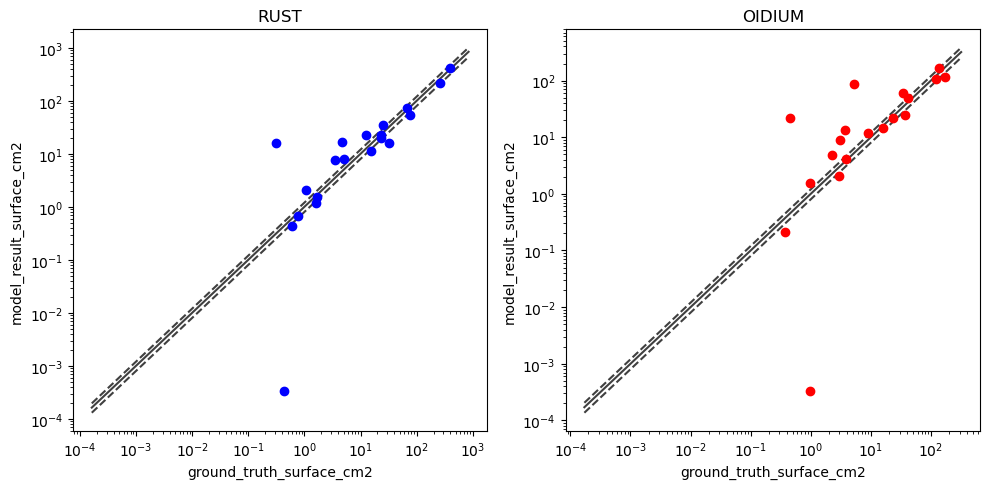

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for rows where class is 'RUST' or 'OIDIUM'
df_rust = df[df['class'] == 'RUST']
df_oidium = df[df['class'] == 'OIDIUM']

# Create a new figure with 2 subplots horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'RUST' class
axs[0].scatter(df_rust['ground_truth_surface_cm2'], df_rust['model_result_surface_cm2'], color='blue')
axs[0].set_title('RUST')

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'OIDIUM' class
axs[1].scatter(df_oidium['ground_truth_surface_cm2'], df_oidium['model_result_surface_cm2'], color='red')
axs[1].set_title('OIDIUM')

# Add a y=x reference line and two dashed lines at y=x±5% to both subplots
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # y=x line
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
    # y=x+5% line
    ax.plot(lims, [lim*1.2 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    # y=x-5% line
    ax.plot(lims, [lim*0.8 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    ax.set_xlabel('ground_truth_surface_cm2')
    ax.set_ylabel('model_result_surface_cm2')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

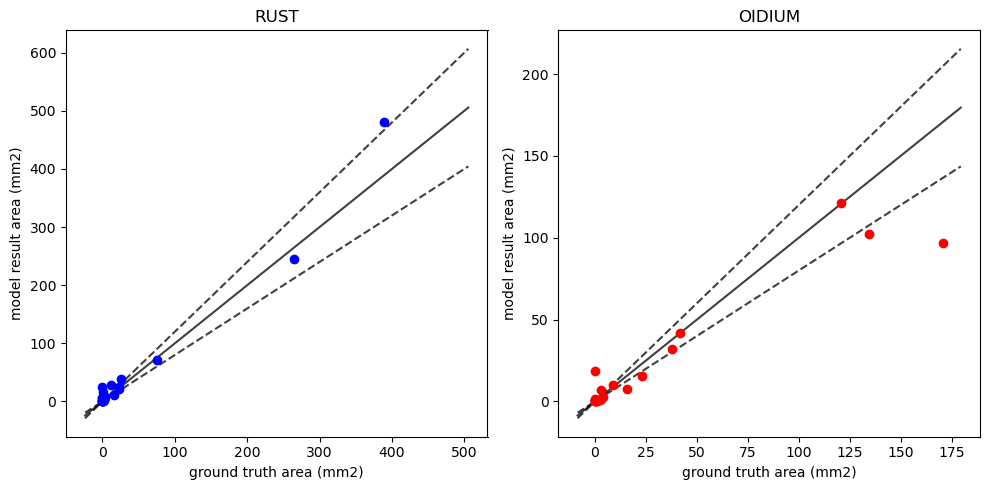

In [121]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import numpy as np

# Exclure les images spécifiques pour le tracé
images_to_exclude = ["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5", "45_leaf2", "410_leaf2", ]
df_rust_plot = df[(df['class'] == 'RUST') & (~df['image'].isin(images_to_exclude))]
df_oidium_plot = df[(df['class'] == 'OIDIUM') & (~df['image'].isin(images_to_exclude))]

# Create a new figure with 2 subplots horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'RUST' class
axs[0].scatter(df_rust_plot['ground_truth_surface_cm2'], df_rust_plot['model_result_surface_cm2'], color='blue')
axs[0].set_title('RUST')

# Create a scatter plot of 'ground_truth_surface_cm2' vs 'model_result_surface_cm2' for 'OIDIUM' class
axs[1].scatter(df_oidium_plot['ground_truth_surface_cm2'], df_oidium_plot['model_result_surface_cm2'], color='red')
axs[1].set_title('OIDIUM')

# Add a y=x reference line and two dashed lines at y=x±5% to both subplots
for ax in axs:
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # y=x line
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    
    # y=x+5% line
    ax.plot(lims, [lim*1.2 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    # y=x-5% line
    ax.plot(lims, [lim*0.8 for lim in lims], 'k--', alpha=0.75, zorder=0)
    
    ax.set_xlabel('ground truth area (mm2)')
    ax.set_ylabel('model result area (mm2)')

# Adjust the layout
plt.tight_layout()

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/feuilles/area_feuille_YUV_trous.pdf", format='pdf')

# Show the plot
plt.show()

In [123]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np

# Supposons que 'df' est votre DataFrame original

# Définir les classes et les colonnes d'intérêt
classes_of_interest = ['OIDIUM', 'RUST']
columns_of_interest = ['precision', 'recall', 'f1', 'IoU', 'ground_truth_surface_cm2', 
                       'model_result_surface_cm2', 'surface_error_cm2', 'surface_error_percent']

# Filtrer le DataFrame pour inclure uniquement les classes d'intérêt
filtered_df = df[df['class'].isin(classes_of_interest)].copy()  # Ajout de .copy() pour éviter l'avertissement

# Remplacer les valeurs 1, 0 par NaN dans les colonnes 'precision', 'recall', 'f1' et 'IoU' en utilisant .loc[]
filtered_df.loc[:, ['precision', 'recall', 'f1', 'IoU']] = filtered_df[['precision', 'recall', 'f1', 'IoU']].replace({1: np.nan, 0: np.nan})

# Remplacer les valeurs de 'surface_error_percent' par NaN lorsque 'ground_truth_surface_cm2' est 0
filtered_df.loc[filtered_df['ground_truth_surface_cm2'] < 1, 'surface_error_percent'] = np.nan

filtered_df.loc[filtered_df['model_result_surface_cm2'] < 1, 'surface_error_percent'] = np.nan

# Remplacer les valeurs de 'surface_error_percent' par NaN lorsque 'surface_error_percent' est supérieur à 200
#filtered_df.loc[filtered_df['surface_error_percent'] > 99, 'surface_error_percent'] = np.nan

# Grouper le DataFrame filtré par classe et calculer la moyenne pour chaque colonne d'intérêt
average_values = filtered_df.groupby('class')[columns_of_interest].mean()

# Afficher les valeurs moyennes pour chaque classe d'intérêt
print(average_values)

        precision    recall        f1       IoU  ground_truth_surface_cm2  \
class                                                                       
OIDIUM   0.443802  0.535438  0.448160  0.326741                 21.864141   
RUST     0.569528  0.587583  0.556296  0.415279                 33.890426   

        model_result_surface_cm2  surface_error_cm2  surface_error_percent  
class                                                                       
OIDIUM                 32.424216          16.707646             157.138952  
RUST                   34.584044           7.276624              51.931997  


In [130]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np

# Supposons que 'df' est votre DataFrame original

# Définir les classes et les colonnes d'intérêt
classes_of_interest = ['OIDIUM', 'RUST']
columns_of_interest = ['precision', 'recall', 'f1', 'IoU', 'ground_truth_surface_cm2', 
                       'model_result_surface_cm2', 'surface_error_cm2', 'surface_error_percent']

# Filtrer le DataFrame pour inclure uniquement les classes d'intérêt
filtered_df = df[df['class'].isin(classes_of_interest)].copy()  # Ajout de .copy() pour éviter l'avertissement

# Exclure les images 4 et 14
#filtered_df = filtered_df[~filtered_df['image'].isin(["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5"])]
filtered_df = filtered_df[~filtered_df['image'].isin(["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5", "45_leaf2", "410_leaf2" ])]

# Remplacer les valeurs 1, 0 par NaN dans les colonnes 'precision', 'recall', 'f1' et 'IoU' en utilisant .loc[]
filtered_df.loc[:, ['precision', 'recall', 'f1', 'IoU']] = filtered_df[['precision', 'recall', 'f1', 'IoU']].replace({1: np.nan, 0: np.nan})

# Remplacer les valeurs de 'surface_error_percent' par NaN lorsque 'ground_truth_surface_cm2' est 0
filtered_df.loc[filtered_df['ground_truth_surface_cm2'] < 1, 'surface_error_percent'] = np.nan


# Remplacer les valeurs de 'surface_error_percent' par NaN lorsque 'surface_error_percent' est supérieur à 200
filtered_df.loc[filtered_df['model_result_surface_cm2'] < 1, 'surface_error_percent'] = np.nan

filtered_df.loc[filtered_df['surface_error_percent'] > 99, 'surface_error_percent'] = np.nan

# Grouper le DataFrame filtré par classe et calculer la moyenne pour chaque colonne d'intérêt
average_values = filtered_df.groupby('class')[columns_of_interest].mean()

# Afficher les valeurs moyennes pour chaque classe d'intérêt
print(average_values)

        precision    recall        f1       IoU  ground_truth_surface_cm2  \
class                                                                       
OIDIUM   0.521495  0.529921  0.508062  0.375549                 25.839421   
RUST     0.617508  0.607994  0.596137  0.453362                 38.066355   

        model_result_surface_cm2  surface_error_cm2  surface_error_percent  
class                                                                       
OIDIUM                 26.022032           8.006792              19.751019  
RUST                   38.746107           7.578745              25.088252  


In [110]:
filtered_df

,image,class,precision,recall,f1,IoU,ground_truth_surface_cm2,model_result_surface_cm2,surface_error_cm2,surface_error_percent
6,478_leaf5,RUST,NaN,NaN,NaN,NaN,0.000000,0.136603,0.136603,NaN
7,478_leaf5,OIDIUM,0.700481,0.699831,0.700156,0.538646,41.874505,41.835664,0.038841,NaN
14,260_leaf4,RUST,NaN,NaN,NaN,NaN,0.000000,5.922964,5.922964,NaN
15,260_leaf4,OIDIUM,0.605768,0.404244,0.484901,0.320046,23.313317,15.557573,7.755745,33.267444
18,664_leaf3,RUST,NaN,NaN,NaN,NaN,0.000000,25.351496,25.351496,NaN
19,664_leaf3,OIDIUM,0.454607,0.389797,0.419715,0.265595,37.727377,32.348849,5.378528,14.256299
22,224_leaf1,RUST,0.309636,0.386575,0.343854,0.207623,1.628042,2.032583,0.404542,24.848362
23,224_leaf1,OIDIUM,NaN,NaN,NaN,NaN,0.000000,0.348584,0.348584,NaN
30,483_leaf2,RUST,0.894430,0.836255,0.864365,0.761129,75.477795,70.568654,4.909141,6.504086
31,483_leaf2,OIDIUM,NaN,NaN,NaN,NaN,0.000000,1.650095,1.650095,NaN


In [147]:
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px

# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['RUST', 'OIDIUM'])

# Add scatter plot for 'RUST' class to the first subplot
fig.add_trace(
    px.scatter(df_rust, x='ground_truth_surface_cm2', y='model_result_surface_cm2', hover_data=['image']).data[0],
    row=1, col=1
)

# Add scatter plot for 'OIDIUM' class to the second subplot
fig.add_trace(
    px.scatter(df_oidium, x='ground_truth_surface_cm2', y='model_result_surface_cm2', hover_data=['image']).data[0],
    row=1, col=2
)

# Get the maximum value for x and y axes
max_value = max(df['ground_truth_surface_cm2'].max(), df['model_result_surface_cm2'].max())

# Add line y=x to both subplots
line1 = go.layout.Shape(type="line", x0=0, y0=0, x1=0.8, y1=0.8, line=dict(color="RoyalBlue", width=2))
line2 = go.layout.Shape(type="line", x0=0, y0=0, x1=0.8, y1=0.8, line=dict(color="RoyalBlue", width=2))
fig.add_shape(line1, row=1, col=1)
fig.add_shape(line2, row=1, col=2)

# Update xaxis and yaxis properties
fig.update_xaxes(title_text='ground_truth_surface_cm2', row=1, col=1)
fig.update_yaxes(title_text='model_result_surface_cm2', row=1, col=1)
fig.update_xaxes(title_text='ground_truth_surface_cm2', row=1, col=2)
fig.update_yaxes(title_text='model_result_surface_cm2', row=1, col=2)

# Update layout to remove background color
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

# Show the plot
fig.show()

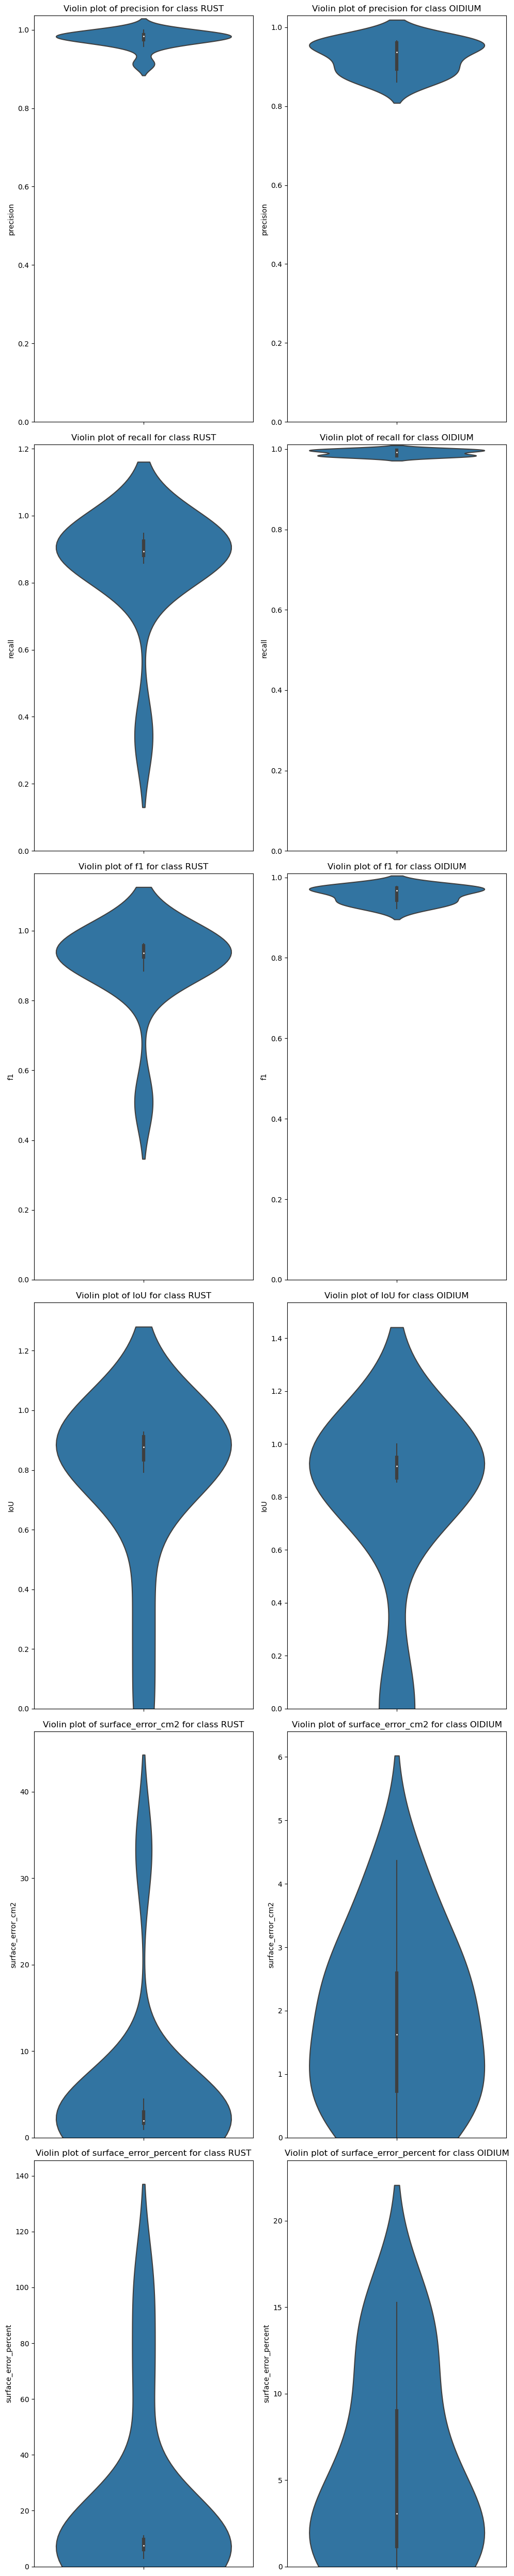

In [165]:
# Importation des bibliothèques nécessaires
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour les classes "RUST" et "OIDIUM"
df_filtered = df[df['class'].isin(['RUST', 'OIDIUM'])]

# Liste des colonnes numériques
columns = ['precision', 'recall', 'f1', 'IoU', 'surface_error_cm2', 'surface_error_percent']

# Créer un subplot pour chaque classe
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(10, 50))

for i, column in enumerate(columns):
    for j, class_name in enumerate(['RUST', 'OIDIUM']):
        df_class = df_filtered[df_filtered['class'] == class_name]
        sns.violinplot(y=column, data=df_class, ax=axs[i, j])
        axs[i, j].set_title(f'Violin plot of {column} for class {class_name}')
        axs[i, j].set_ylim(0,)  # Set the lower limit of y-axis to 0

plt.tight_layout()
plt.show()

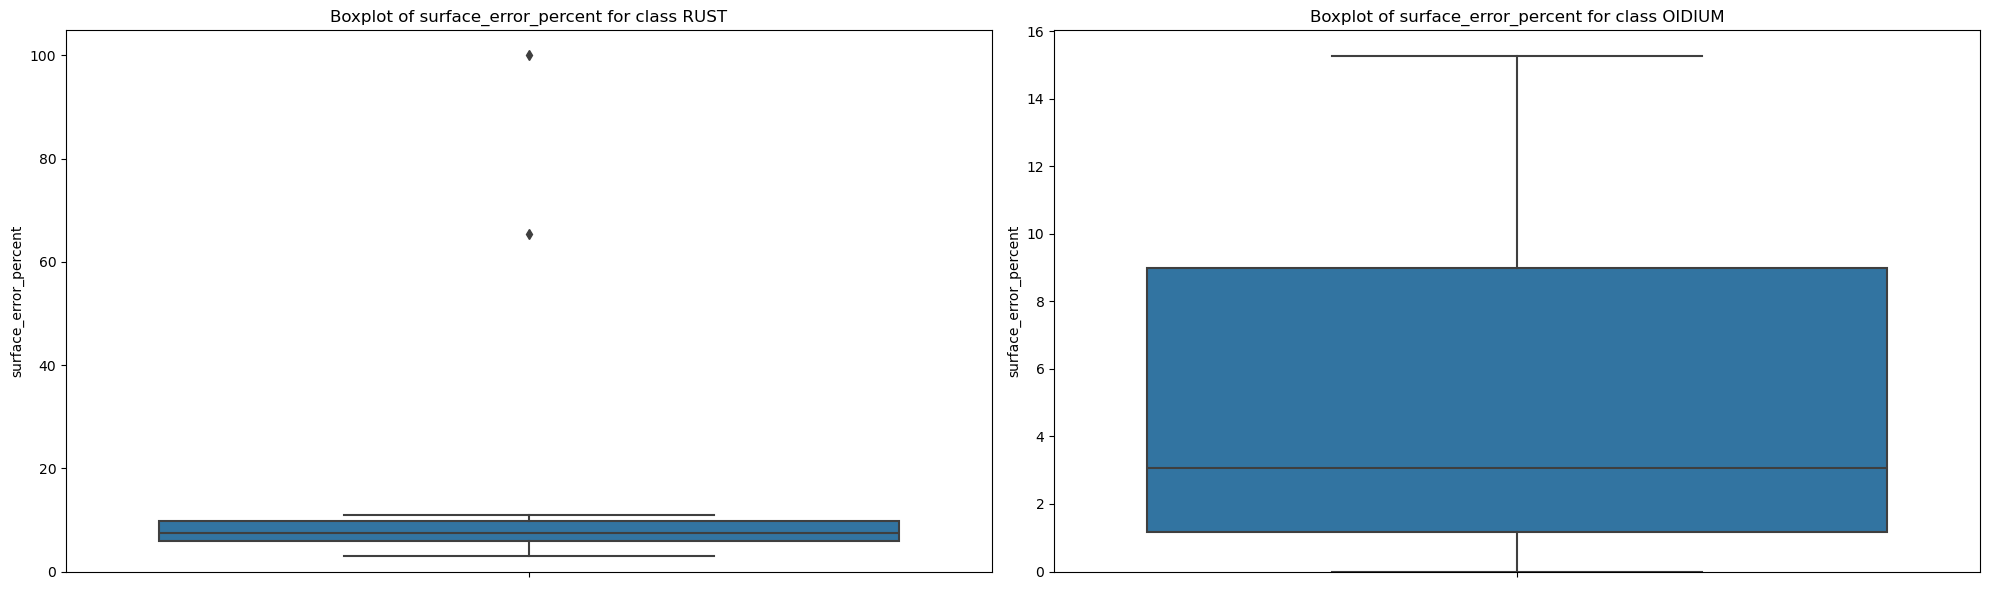

In [166]:
# Importation des bibliothèques nécessaires
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour les classes "RUST" et "OIDIUM"
df_filtered = df[df['class'].isin(['RUST', 'OIDIUM'])]

# Créer un subplot pour chaque classe
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

for i, class_name in enumerate(['RUST', 'OIDIUM']):
    df_class = df_filtered[df_filtered['class'] == class_name]
    sns.boxplot(y='surface_error_percent', data=df_class, ax=axs[i])
    axs[i].set_title(f'Boxplot of surface_error_percent for class {class_name}')
    axs[i].set_ylim(0,)  # Set the lower limit of y-axis to 0

plt.tight_layout()
plt.show()

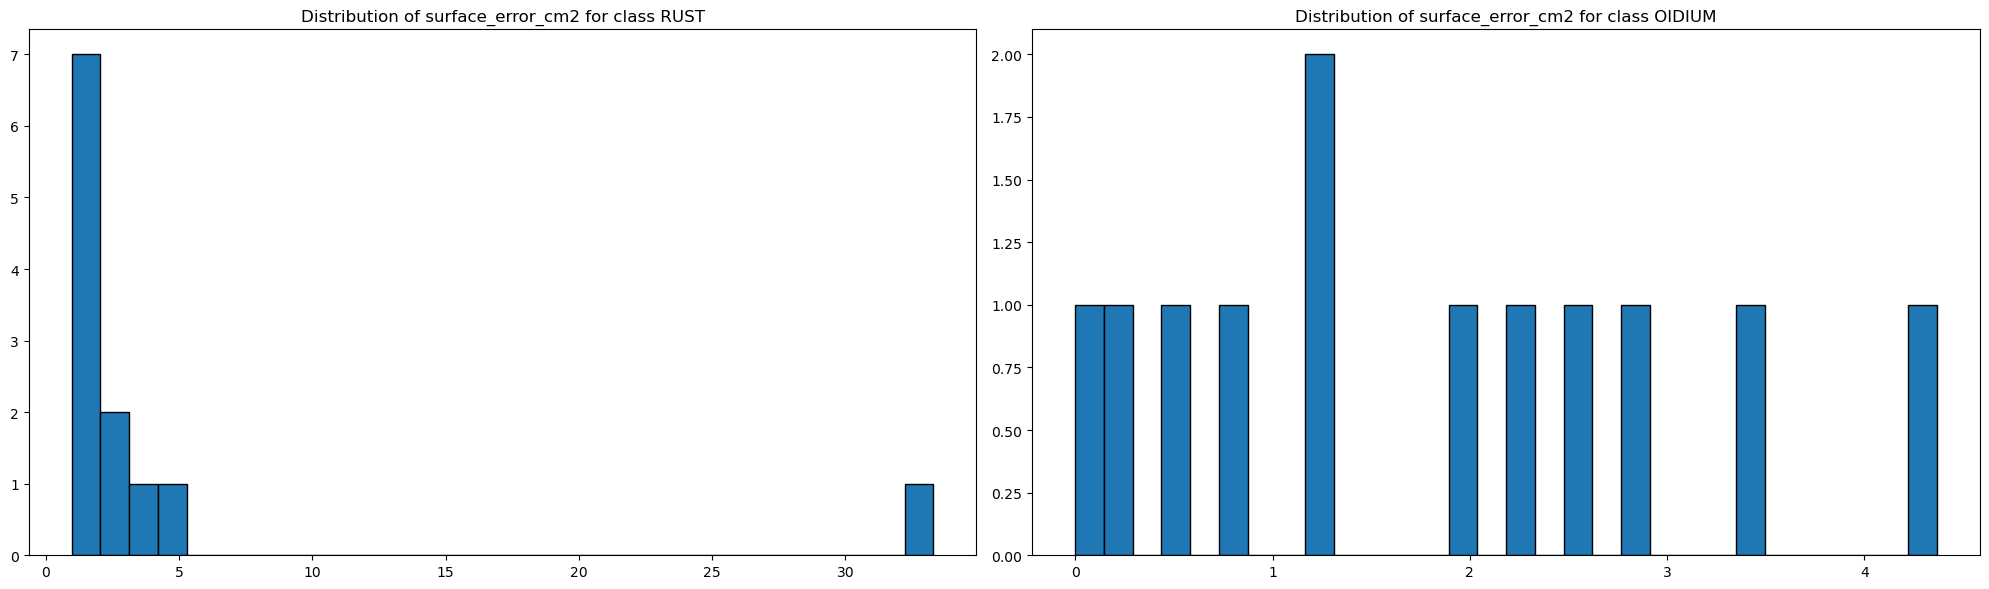

In [167]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour les classes "RUST" et "OIDIUM"
df_filtered = df[df['class'].isin(['RUST', 'OIDIUM'])]

# Créer un histogramme pour chaque classe
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

for i, class_name in enumerate(['RUST', 'OIDIUM']):
    df_class = df_filtered[df_filtered['class'] == class_name]
    axs[i].hist(df_class['surface_error_cm2'], bins=30, edgecolor='black')
    axs[i].set_title(f'Distribution of surface_error_cm2 for class {class_name}')
    axs[i].set_ylim(0,)  # Set the lower limit of y-axis to 0

plt.tight_layout()
plt.show()

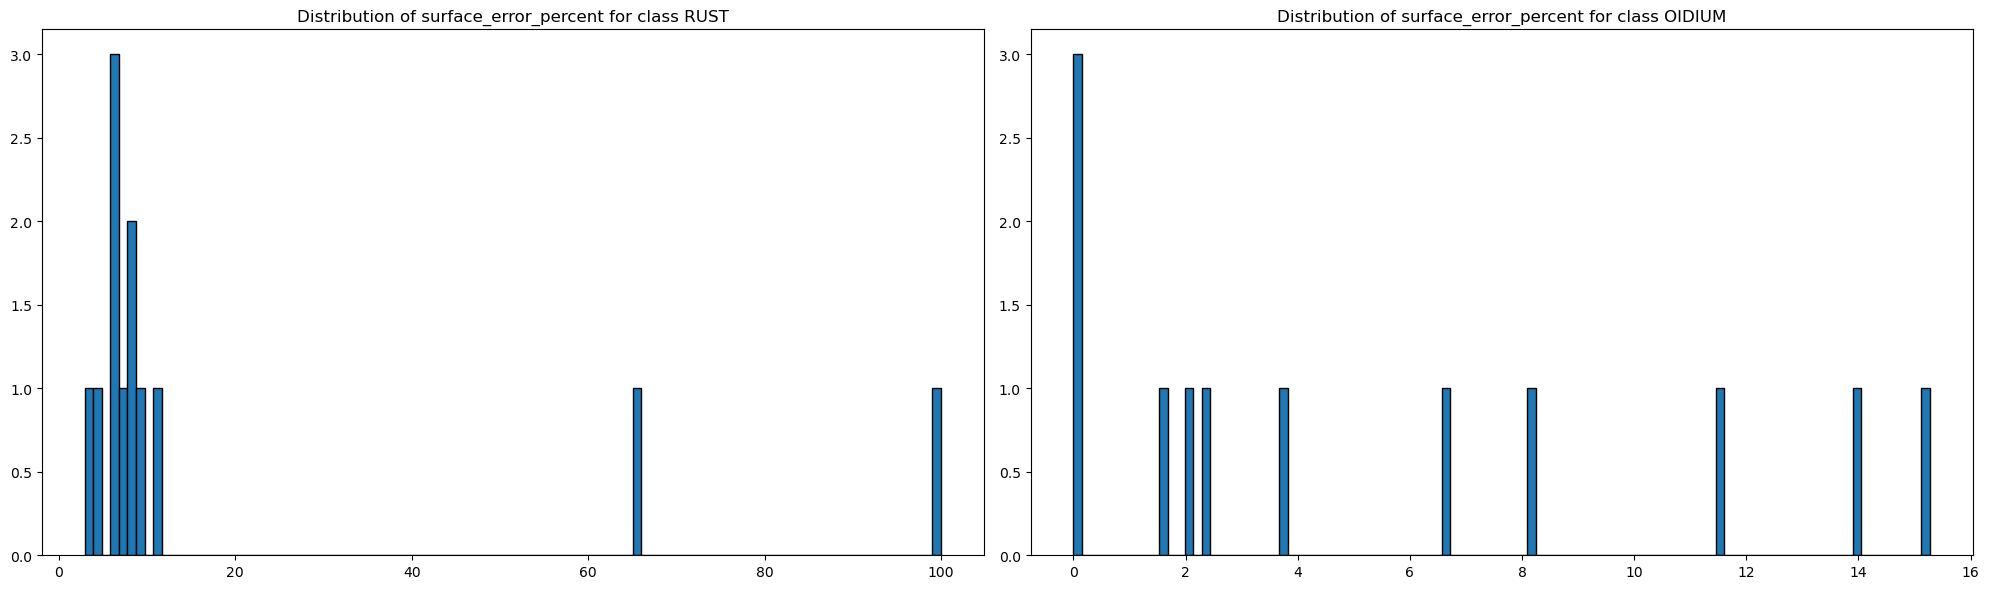

In [168]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour les classes "RUST" et "OIDIUM"
df_filtered = df[df['class'].isin(['RUST', 'OIDIUM'])]

# Créer un histogramme pour chaque classe
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

for i, class_name in enumerate(['RUST', 'OIDIUM']):
    df_class = df_filtered[df_filtered['class'] == class_name]
    axs[i].hist(df_class['surface_error_percent'], bins=100, edgecolor='black')
    axs[i].set_title(f'Distribution of surface_error_percent for class {class_name}')
    axs[i].set_ylim(0,)  # Set the lower limit of y-axis to 0

plt.tight_layout()
plt.show()

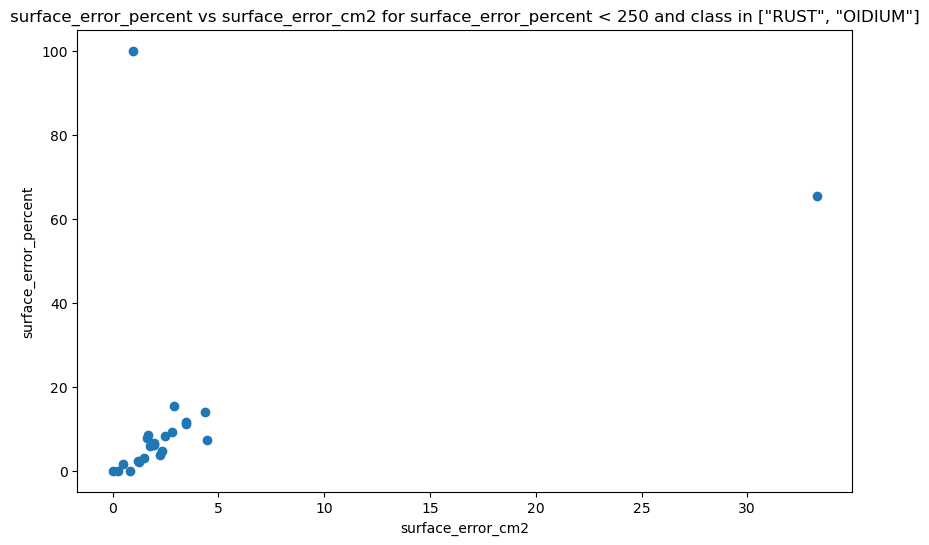

In [169]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt

# Filtrer le DataFrame
df_filtered = df[(df['surface_error_percent'] < 250) & (df['class'].isin(['RUST', 'OIDIUM']))]

# Créer un scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['surface_error_cm2'], df_filtered['surface_error_percent'])
plt.xlabel('surface_error_cm2')
plt.ylabel('surface_error_percent')
plt.title('surface_error_percent vs surface_error_cm2 for surface_error_percent < 250 and class in ["RUST", "OIDIUM"]')
plt.show()

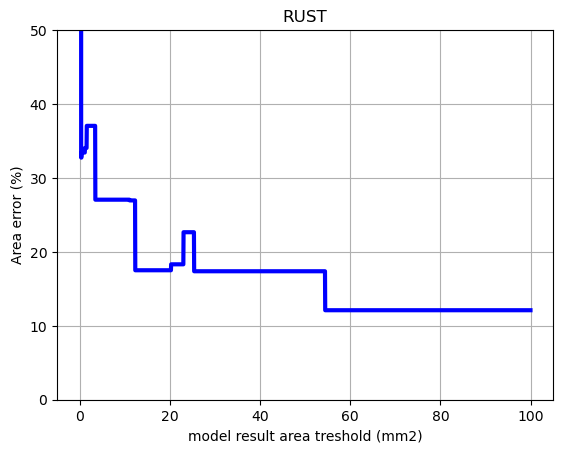

In [168]:
import matplotlib.pyplot as plt

# Liste des images à exclure
images_to_exclude = ["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5", "45_leaf2", "410_leaf2"]

# Créer un masque pour les images à inclure
mask = ~df['image'].isin(images_to_exclude)

# Filtrer les données pour la classe OIDIUM et les images à inclure
df_oidium = df[(df['class'] == 'RUST') & mask] #& (df['surface_error_percent'] < 99)

# Définir les seuils
thresholds = np.arange(0, 100, 0.05)

# Initialiser une liste pour stocker les moyennes de précision
precision_means = []

# Pour chaque seuil, filtrer les données et calculer la moyenne de la précision
for threshold in thresholds:
    df_threshold = df_oidium[(df_oidium['model_result_surface_cm2'] > threshold) & (df_oidium['ground_truth_surface_cm2'] > threshold)]
    precision_mean = df_threshold['surface_error_percent'].mean() # surface_error_percent
    precision_means.append(precision_mean)

# Tracer les résultats
plt.plot(thresholds, precision_means, linewidth=3, color="blue")
plt.title('RUST')
#plt.title('Moyenne de la précision pour la classe OIDIUM en fonction du seuil de model_result_surface_cm2')
plt.xlabel('model result area treshold (mm2)')
plt.ylabel('Area error (%)')
plt.ylim(0, 50)
plt.grid(True)

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/treshold_RUST.pdf", format='pdf')

plt.show()

In [164]:
df_oidium

,image,class,precision,recall,f1,IoU,ground_truth_surface_cm2,model_result_surface_cm2,surface_error_cm2,surface_error_percent
7,478_leaf5,OIDIUM,0.752605,0.882372,0.812339,0.683982,41.874505,49.094701,7.220196,17.242464
15,260_leaf4,OIDIUM,0.641160,0.594231,0.616804,0.445927,23.313317,21.606935,1.706382,7.319346
19,664_leaf3,OIDIUM,0.607139,0.402160,0.483835,0.319118,37.727377,24.990075,12.737302,33.761429
23,224_leaf1,OIDIUM,NaN,NaN,NaN,0.000000,0.000000,0.612902,0.612902,0.000000
31,483_leaf2,OIDIUM,NaN,NaN,NaN,0.000000,0.000000,2.706380,2.706380,0.000000
35,327_leaf3,OIDIUM,0.674029,0.484900,0.564032,0.392789,2.920995,2.101378,0.819617,28.059500
39,474_leaf3,OIDIUM,0.917719,0.623127,0.742262,0.590156,170.997354,116.106417,54.890937,32.100460
47,119_leaf3,OIDIUM,0.110709,0.176391,0.136037,0.072982,0.970373,1.546080,0.575707,59.328358
55,171_leaf5,OIDIUM,NaN,NaN,NaN,0.000000,0.961815,0.000329,0.961486,99.965777
59,22_leaf5,OIDIUM,NaN,NaN,NaN,0.000000,0.000000,0.691901,0.691901,0.000000


In [106]:
import matplotlib.pyplot as plt

# Liste des images à exclure
images_to_exclude = ["111_leaf2", "654_leaf4", "269_leaf3", "376_leaf5", "45_leaf2", "410_leaf2"]

# Créer un masque pour les images à inclure
mask = ~df['image'].isin(images_to_exclude)

# Filtrer les données pour la classe OIDIUM et les images à inclure
df_oidium = df[(df['class'] == 'RUST') & mask & (df['ground_truth_surface_cm2'] > 1)] #& (df['surface_error_percent'] < 99)

precision_mean = df_oidium['surface_error_percent'].mean()

print(f"Moyenne de la précision pour la classe OIDIUM: {precision_mean:.2f}")

Moyenne de la précision pour la classe OIDIUM: 262.86


In [107]:
df_oidium

,image,class,precision,recall,f1,IoU,ground_truth_surface_cm2,model_result_surface_cm2,surface_error_cm2,surface_error_percent
6,478_leaf5,RUST,NaN,NaN,NaN,0.000000,0.000000,0.136603,0.136603,0.000000
14,260_leaf4,RUST,NaN,NaN,NaN,0.000000,0.000000,5.922964,5.922964,0.000000
18,664_leaf3,RUST,NaN,NaN,NaN,0.000000,0.000000,25.351496,25.351496,0.000000
22,224_leaf1,RUST,0.309636,0.386575,0.343854,0.207623,1.628042,2.032583,0.404542,24.848362
30,483_leaf2,RUST,0.894430,0.836255,0.864365,0.761129,75.477795,70.568654,4.909141,6.504086
34,327_leaf3,RUST,0.460278,0.541093,0.497424,0.331048,1.674124,1.968067,0.293943,17.558002
38,474_leaf3,RUST,NaN,NaN,NaN,0.000000,0.000000,0.025346,0.025346,0.000000
46,119_leaf3,RUST,NaN,NaN,NaN,0.000000,0.000000,5.578330,5.578330,0.000000
54,171_leaf5,RUST,NaN,NaN,NaN,0.000000,0.489137,0.000000,0.489137,100.000000
58,22_leaf5,RUST,NaN,NaN,NaN,0.000000,0.000000,0.074062,0.074062,0.000000


---
## Feature selection data

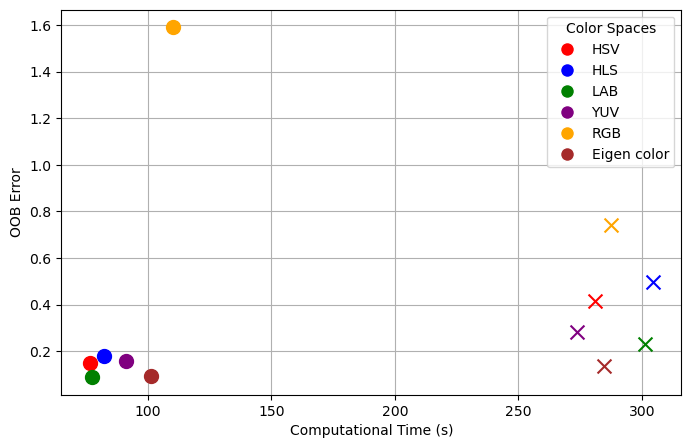

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# DataFrame with color spaces, computing time and OOB error
data = pd.DataFrame({
  'color_space': ["RGB", "RGB", "HSV", "HSV", "HLS", "HLS", "LAB", "LAB", "YUV", "YUV", "Eigen color", "Eigen color"],
  'time': [287.649, 110.318, 280.959, 76.390, 304.559, 82.116, 301.374, 77.570, 273.799, 91.229, 284.490, 101.240],
  'oob_error': [0.742, 1.590, 0.417, 0.152, 0.496, 0.181, 0.230, 0.089, 0.284, 0.157, 0.136, 0.095],
  'all_features': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
})

# Define a color dictionary for each color space
color_dict = {"HSV": "red", "HLS": "blue", "LAB": "green", "YUV": "purple", "RGB": "orange", "Eigen color": "brown"}

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter plot with different markers for all features and color spaces
for i in range(len(data)):
    marker = 'x' if data['all_features'][i] else 'o'
    ax.scatter(data['time'][i], data['oob_error'][i], color=color_dict[data['color_space'][i]], marker=marker, s=100)

# Create a legend with the color dictionary
color_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[key], markersize=10) for key in color_dict.keys()]
ax.legend(color_legend, color_dict.keys(), title="Color Spaces", loc="upper right")

ax.set_xlabel('Computational Time (s)')
ax.set_ylabel('OOB Error')
ax.grid(True)
ax.set_axisbelow(True)

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/OOB_time.pdf", format='pdf')

plt.show()

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# metrics BEFORE post processing
data_before = pd.DataFrame({
  'color_space': ["RGB", "RGB", "HSV", "HSV", "LAB", "LAB"],
  'disease': ["OIDIUM", "RUST", "OIDIUM", "RUST", "OIDIUM", "RUST"],
  'precision': [0.957, 0.986, 0.964, 0.986, 0.987, 0.993],
  'recall': [0.833, 0.810, 0.851, 0.846, 0.934, 0.807],
  'f1': [0.887, 0.879, 0.903, 0.900, 0.960, 0.879],
  'IoU': [0.8, 0.802, 0.826, 0.838, 0.923, 0.802],
  'area_error': [13.15, 17.97, 11.57, 14.39, 5.31, 18.77]
})

# metrics AFTER post processing
data_after = pd.DataFrame({
  'color_space': ["RGB", "RGB", "HSV", "HSV", "LAB", "LAB"],
  'disease': ["OIDIUM", "RUST", "OIDIUM", "RUST", "OIDIUM", "RUST"],
  'precision': [0.851, 0.963, 0.909, 0.964, 0.925, 0.975],
  'recall': [0.98, 0.85, 0.979, 0.885, 0.991, 0.855],
  'f1': [0.908, 0.893, 0.941, 0.910, 0.956, 0.899],
  'IoU': [0.838, 0.824, 0.891, 0.855, 0.917, 0.836],
  'area_error': [17.82, 12.42, 8.62, 10.46, 7.26, 12.28]
})

# difference between metrics before and after post processing
diff_data = data_after.copy()
diff_data['precision'] = data_after['precision'] - data_before['precision']
diff_data['recall'] = data_after['recall'] - data_before['recall']
diff_data['f1'] = data_after['f1'] - data_before['f1']
diff_data['IoU'] = data_after['IoU'] - data_before['IoU']
diff_data['area_error'] = data_after['area_error'] - data_before['area_error']

diff_data

,color_space,disease,precision,recall,f1,IoU,area_error
0,RGB,OIDIUM,-0.106,0.147,0.021,0.038,4.67
1,RGB,RUST,-0.023,0.040,0.014,0.022,-5.55
2,HSV,OIDIUM,-0.055,0.128,0.038,0.065,-2.95
3,HSV,RUST,-0.022,0.039,0.010,0.017,-3.93
4,LAB,OIDIUM,-0.062,0.057,-0.004,-0.006,1.95
5,LAB,RUST,-0.018,0.048,0.020,0.034,-6.49


In [67]:
import matplotlib.pyplot as plt
import pandas as pd
# SANS OUTLIER
# metrics BEFORE post processing
data_before = pd.DataFrame({
  'color_space': ["RGB", "RGB", "HSV", "HSV", "LAB", "LAB"],
  'disease': ["OIDIUM", "RUST", "OIDIUM", "RUST", "OIDIUM", "RUST"],
  'precision': [0.957, 0.986, 0.964, 0.986, 0.987, 0.993],
  'recall': [0.833, 0.810, 0.851, 0.846, 0.934, 0.807],
  'f1': [0.887, 0.879, 0.903, 0.900, 0.960, 0.879],
  'IoU': [0.8, 0.802, 0.826, 0.838, 0.923, 0.802],
  'area_error': [14.781, 12.889, 11.57, 9.168, 5.31, 13.86]
})

# metrics AFTER post processing
data_after = pd.DataFrame({
  'color_space': ["RGB", "RGB", "HSV", "HSV", "LAB", "LAB"],
  'disease': ["OIDIUM", "RUST", "OIDIUM", "RUST", "OIDIUM", "RUST"],
  'precision': [0.851, 0.963, 0.909, 0.964, 0.925, 0.975],
  'recall': [0.98, 0.85, 0.979, 0.885, 0.991, 0.855],
  'f1': [0.908, 0.893, 0.941, 0.910, 0.956, 0.899],
  'IoU': [0.838, 0.824, 0.891, 0.855, 0.917, 0.836],
  'area_error': [17.82, 7.07, 9.59, 5.12, 7.26, 6.97]
})

# difference between metrics before and after post processing
diff_data = data_after.copy()
diff_data['precision'] = data_after['precision'] - data_before['precision']
diff_data['recall'] = data_after['recall'] - data_before['recall']
diff_data['f1'] = data_after['f1'] - data_before['f1']
diff_data['IoU'] = data_after['IoU'] - data_before['IoU']
diff_data['area_error'] = data_after['area_error'] - data_before['area_error']

diff_data

,color_space,disease,precision,recall,f1,IoU,area_error
0,RGB,OIDIUM,-0.106,0.147,0.021,0.038,3.039
1,RGB,RUST,-0.023,0.040,0.014,0.022,-5.819
2,HSV,OIDIUM,-0.055,0.128,0.038,0.065,-1.980
3,HSV,RUST,-0.022,0.039,0.010,0.017,-4.048
4,LAB,OIDIUM,-0.062,0.057,-0.004,-0.006,1.950
5,LAB,RUST,-0.018,0.048,0.020,0.034,-6.890


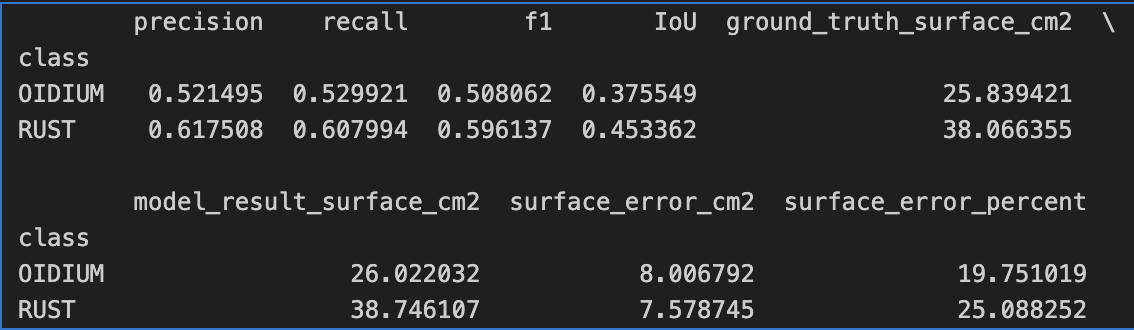

In [145]:
# metrics AFTER post processing
data_after = pd.DataFrame({
  'color_space': ["LAB", "LAB", "HSV", "HSV", "RGB", "RGB"],
  'disease': ["OIDIUM", "RUST", "OIDIUM", "RUST", "OIDIUM", "RUST"],
  'precision': [0.52, 0.62, 0.909, 0.964, 0.987, 0.993],
  'recall': [0.53, 0.61, 0.979, 0.885, 0.934, 0.807],
  'f1': [0.51, 0.6, 0.941, 0.910, 0.960, 0.879],
  'IoU': [0.38, 0.45, 0.891, 0.855, 0.923, 0.802],
  'area_error': [19.75, 25.08, 9.59, 5.12, 5.31, 13.86]
})

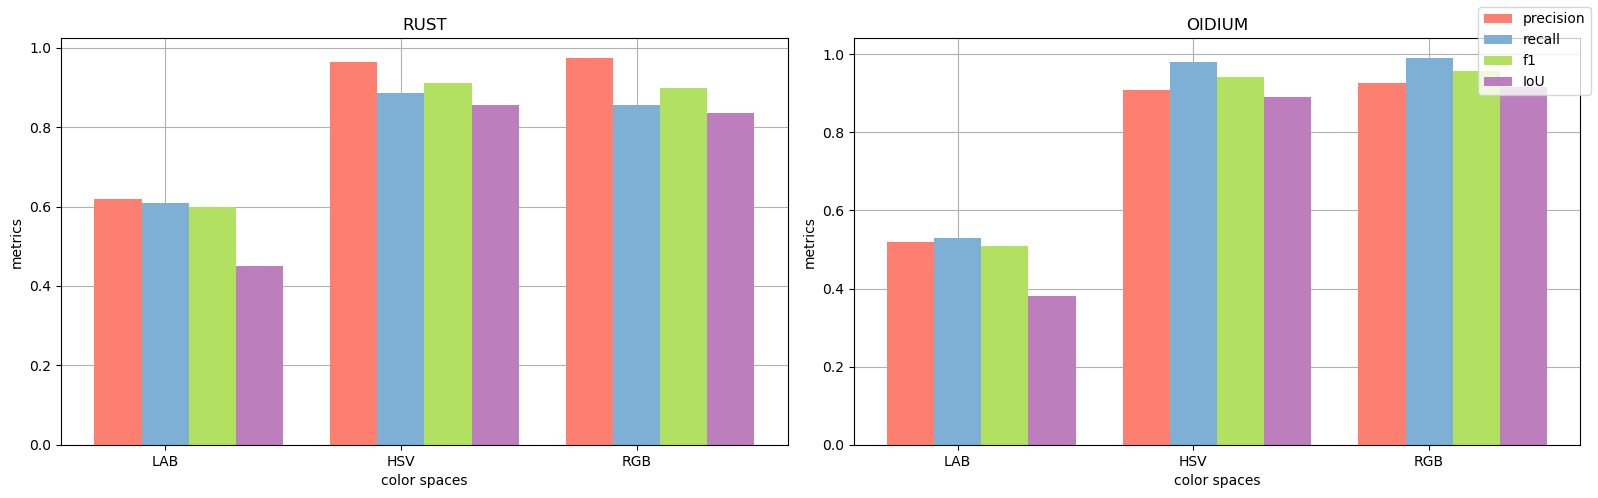

In [134]:
# Filter data for each disease
#oidium_data = data_before[data_before['disease'] == 'OIDIUM']
#rust_data = data_before[data_before['disease'] == 'RUST']
oidium_data = data_after[data_after['disease'] == 'OIDIUM']
rust_data = data_after[data_after['disease'] == 'RUST']

# Define the width of the bars
bar_width = 0.2

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Create bars for OIDIUM
r1 = np.arange(len(oidium_data['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[1].bar(r1, oidium_data['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[1].bar(r2, oidium_data['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[1].bar(r3, oidium_data['f1'], color='#b2e061', width=bar_width, label='f1')
ax[1].bar(r4, oidium_data['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[1].set_xlabel('color spaces')
ax[1].set_ylabel('metrics')
ax[1].set_xticks([r + bar_width for r in range(len(oidium_data['precision']))])
ax[1].set_xticklabels(oidium_data['color_space'])
ax[1].set_title('OIDIUM')
ax[1].grid(True)
ax[1].set_axisbelow(True)

# Create bars for RUST
r1 = np.arange(len(rust_data['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[0].bar(r1, rust_data['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[0].bar(r2, rust_data['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[0].bar(r3, rust_data['f1'], color='#b2e061', width=bar_width, label='f1')
ax[0].bar(r4, rust_data['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[0].set_xlabel('color spaces')
ax[0].set_ylabel('metrics')
ax[0].set_xticks([r + bar_width for r in range(len(rust_data['precision']))])
ax[0].set_xticklabels(rust_data['color_space'])
ax[0].set_title('RUST')
ax[0].grid(True)
ax[0].set_axisbelow(True)

# Create a single legend for the whole figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

#plt.savefig("/Users/titouanlegourrierec/Desktop/figures/metrics_color_space_morph.pdf", format='pdf')

# Show the plot
plt.tight_layout()
plt.show()

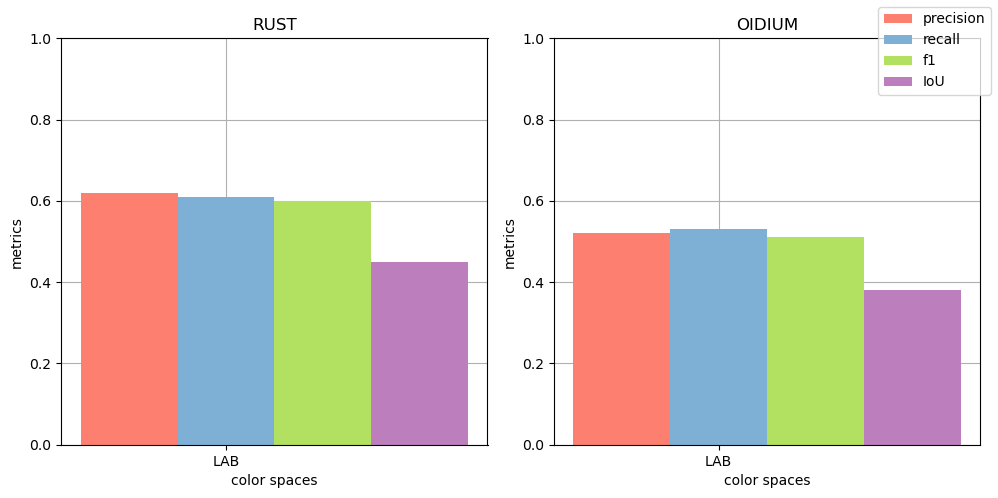

In [146]:
# Filter data for RGB color space
oidium_data = data_after[data_after['disease'] == 'OIDIUM']
rust_data = data_after[data_after['disease'] == 'RUST']

oidium_data_rgb = oidium_data[oidium_data['color_space'] == 'LAB']
rust_data_rgb = rust_data[rust_data['color_space'] == 'LAB']

# Define the width of the bars
bar_width = 0.2

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create bars for OIDIUM - RGB
r1 = np.arange(len(oidium_data_rgb['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[1].bar(r1, oidium_data_rgb['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[1].bar(r2, oidium_data_rgb['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[1].bar(r3, oidium_data_rgb['f1'], color='#b2e061', width=bar_width, label='f1')
ax[1].bar(r4, oidium_data_rgb['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[1].set_xlabel('color spaces')
ax[1].set_ylabel('metrics')
ax[1].set_xticks([r + bar_width for r in range(len(oidium_data_rgb['precision']))])
ax[1].set_xticklabels(oidium_data_rgb['color_space'])
ax[1].set_title('OIDIUM')
ax[1].grid(True)
ax[1].set_axisbelow(True)
ax[1].set_ylim(0, 1)

# Create bars for RUST - RGB
r1 = np.arange(len(rust_data_rgb['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[0].bar(r1, rust_data_rgb['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[0].bar(r2, rust_data_rgb['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[0].bar(r3, rust_data_rgb['f1'], color='#b2e061', width=bar_width, label='f1')
ax[0].bar(r4, rust_data_rgb['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[0].set_xlabel('color spaces')
ax[0].set_ylabel('metrics')
ax[0].set_xticks([r + bar_width for r in range(len(rust_data_rgb['precision']))])
ax[0].set_xticklabels(rust_data_rgb['color_space'])
ax[0].set_title('RUST')
ax[0].grid(True)
ax[0].set_axisbelow(True)
ax[0].set_ylim(0, 1)

# Create a single legend for the whole figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Show the plot
plt.tight_layout()

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/LAB_mauvais.pdf", format='pdf')

plt.show()


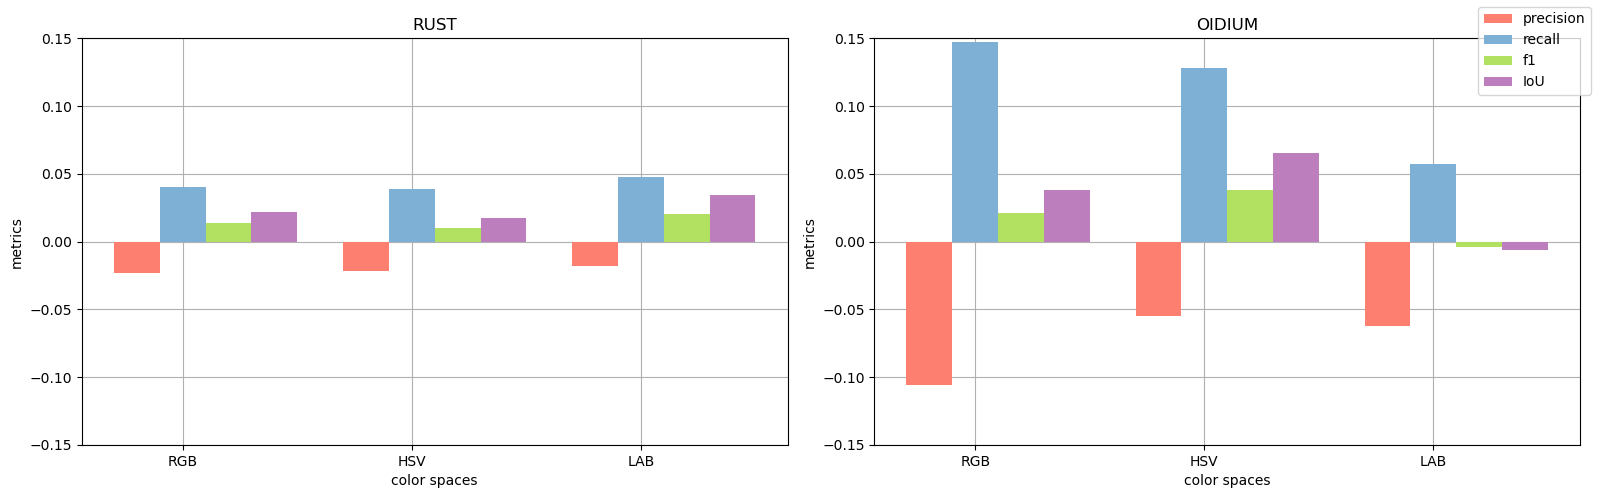

In [178]:
# Filter data for each disease
oidium_data = diff_data[diff_data['disease'] == 'OIDIUM']
rust_data = diff_data[diff_data['disease'] == 'RUST']

# Define the width of the bars
bar_width = 0.2

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Create bars for OIDIUM
r1 = np.arange(len(oidium_data['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[1].bar(r1, oidium_data['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[1].bar(r2, oidium_data['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[1].bar(r3, oidium_data['f1'], color='#b2e061', width=bar_width, label='f1')
ax[1].bar(r4, oidium_data['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[1].set_xlabel('color spaces')
ax[1].set_ylabel('metrics')
ax[1].set_xticks([r + bar_width for r in range(len(oidium_data['precision']))])
ax[1].set_xticklabels(oidium_data['color_space'])
ax[1].set_title('OIDIUM')
ax[1].grid(True)
ax[1].set_axisbelow(True)
ax[1].set_ylim(-0.15, 0.15)

# Create bars for RUST
r1 = np.arange(len(rust_data['precision']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax[0].bar(r1, rust_data['precision'], color='#fd7f6f', width=bar_width, label='precision')
ax[0].bar(r2, rust_data['recall'], color='#7eb0d5', width=bar_width, label='recall')
ax[0].bar(r3, rust_data['f1'], color='#b2e061', width=bar_width, label='f1')
ax[0].bar(r4, rust_data['IoU'], color='#bd7ebe', width=bar_width, label='IoU')

# Adding xticks
ax[0].set_xlabel('color spaces')
ax[0].set_ylabel('metrics')
ax[0].set_xticks([r + bar_width for r in range(len(rust_data['precision']))])
ax[0].set_xticklabels(rust_data['color_space'])
ax[0].set_title('RUST')
ax[0].grid(True)
ax[0].set_axisbelow(True)
ax[0].set_ylim(-0.15, 0.15)

# Create a single legend for the whole figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/metrics_color_space_morph.pdf", format='pdf')

# Show the plot
plt.tight_layout()
plt.show()

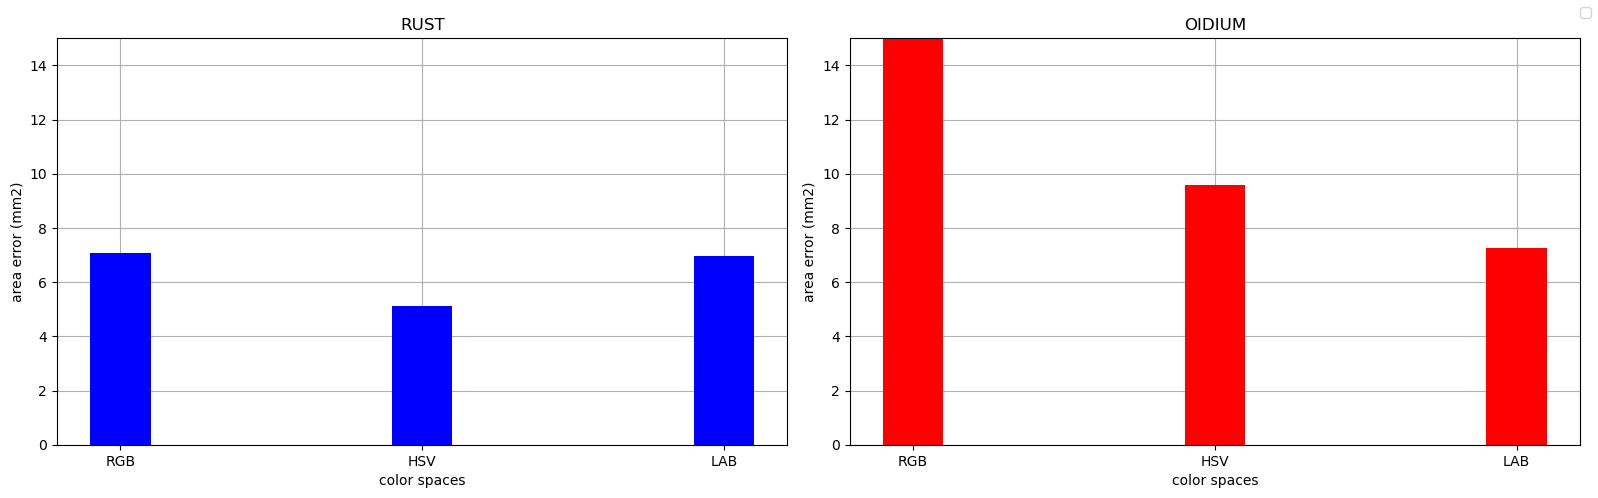

In [66]:
# Filter data for each disease
#oidium_data = data_before[data_before['disease'] == 'OIDIUM']
# rust_data = data_before[data_before['disease'] == 'RUST']
oidium_data = data_after[data_after['disease'] == 'OIDIUM']
rust_data = data_after[data_after['disease'] == 'RUST']

# Define the width of the bars
bar_width = 0.2

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Create bars for OIDIUM
r1 = np.arange(len(oidium_data['area_error']))

ax[1].bar(r1, oidium_data['area_error'], color='red', width=bar_width)

# Adding xticks
ax[1].set_xlabel('color spaces')
ax[1].set_ylabel('area error (mm2)')
ax[1].set_xticks(r1)  # Adjust xticks position
ax[1].set_xticklabels(oidium_data['color_space'])
ax[1].set_title('OIDIUM')
ax[1].grid(True)
ax[1].set_axisbelow(True)
ax[1].set_ylim([0, 15])

# Create bars for RUST
r1 = np.arange(len(rust_data['area_error']))

ax[0].bar(r1, rust_data['area_error'], color='blue', width=bar_width)

# Adding xticks
ax[0].set_xlabel('color spaces')
ax[0].set_ylabel('area error (mm2)')
ax[0].set_xticks(r1)  # Adjust xticks position
ax[0].set_xticklabels(rust_data['color_space'])
ax[0].set_title('RUST')
ax[0].grid(True)
ax[0].set_axisbelow(True)
ax[0].set_ylim([0, 15])

# Create a single legend for the whole figure
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.savefig("/Users/titouanlegourrierec/Desktop/figures/patchs/area_morph/area_error_color_space_morph.pdf", format='pdf')

# Show the plot
plt.tight_layout()
plt.show()